# Setup

In [1]:
import pymongo
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import timedelta
from iso8601 import parse_date

sns.set_theme(style="darkgrid")

season_start = parse_date("2020-11-03T15:34:26.970Z") - timedelta(minutes=30)
season_end = parse_date("2020-11-14T21:20:45.326Z") + timedelta(minutes=30)

client = pymongo.MongoClient()
db = client.tpp3
collection = db.matches.find({"finished_at": {"$gt": season_start, "$lt": season_end}})
data = pd.DataFrame(list(collection))
keys = list(data.keys())
to_drop = ["game","avatars","teams","base_metagames","base_gimmicks"]
for i in to_drop:
    if i in keys:
        data = data.drop([i], axis=1)

data.result = pd.to_numeric(data.result, errors="coerce")

data["duration"] = data.finished_at - data.started_at
data = data.drop(["started_at","finished_at","created_at"],axis=1)

data[["odds","blue_odds"]] = pd.DataFrame(data.pokeyen_odds.to_list(), index=data.index)
data["winner_odds"] = [data.odds[i] if result==1 else data.blue_odds[i] for i,result in enumerate(data["result"])]
data = data.drop(["pokeyen_odds","blue_odds"],axis=1)

data["num_bettors"] = data.pokeyen_bets.str.len() # magic I guess
data = data.drop(["pokeyen_bets"], axis=1)

# TODO there has to be a better way
average_bet = []
total_bonus = []
collection = db.matches.find({"finished_at": {"$gt": season_start, "$lt": season_end}}) # it broke without resetting collection here
for i, match in enumerate(collection):
    average_bet.append(0.0 if len(match["pokeyen_bets"]) == 0
        else statistics.mean(v["amount"] for v in match["pokeyen_bets"].values()))
    if "bet_bonus" in match["pokeyen_bets"]:
        total_bonus.append(0.0 if len(match["pokeyen_bets"]) == 0 or match["result"] == None
            else (sum(bet["amount"]*bet["bet_bonus"]/100 for bet in match["pokeyen_bets"].values() if bet["team"] == match["result"])))
data["average_bet"] = pd.DataFrame(average_bet)
if len(total_bonus) > 0:
    data["bet_bonus_amount"] = pd.DataFrame(total_bonus)
del average_bet

keys = list(data.keys())
nonzero_bets = data[data.average_bet > 0]

data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1487 entries, 0 to 1486
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   _id          1487 non-null   int64          
 1   result       1462 non-null   float64        
 2   stage        1487 non-null   object         
 3   metagame     1487 non-null   object         
 4   gimmick      1487 non-null   object         
 5   switching    1487 non-null   object         
 6   custom       1487 non-null   bool           
 7   duration     1487 non-null   timedelta64[ns]
 8   odds         1487 non-null   float64        
 9   winner_odds  1487 non-null   float64        
 10  num_bettors  1487 non-null   int64          
 11  average_bet  1487 non-null   float64        
dtypes: bool(1), float64(4), int64(2), object(4), timedelta64[ns](1)
memory usage: 129.4+ KB


,_id,result,stage,metagame,gimmick,switching,custom,duration,odds,winner_odds,num_bettors,average_bet
0,161730,0.0,sunny_park,halloween,normal,never,False,0 days 00:06:08.461000,1.823775,0.548313,30,856.733333
1,161731,0.0,courtyard,halloween,fog,always,False,0 days 00:08:52.336000,0.245402,4.074942,29,1127.862069
2,161732,1.0,stargazer,halloween,normal,never,False,0 days 00:09:15.003000,1.147709,1.147709,33,1191.848485
3,161733,1.0,lagoon,halloween,singles_combo_of_4,never,True,0 days 00:07:59.252000,1.450126,1.450126,25,663.200000
4,161734,0.0,neon,halloween,afflicted,always,False,0 days 00:02:18.730000,1.776014,0.563059,28,574.535714
...,...,...,...,...,...,...,...,...,...,...,...,...
1482,163212,1.0,waterfall,halloween,inverse,never,False,0 days 00:04:02.097000,1.781591,1.781591,38,1350.315789
1483,163213,1.0,neon,halloween,normal,never,False,0 days 00:04:54.877000,1.829990,1.829990,37,1685.297297
1484,163214,0.0,neon,halloween,normal,never,False,0 days 00:05:52.059000,2.922237,0.342204,45,1213.888889
1485,163215,0.0,sunset,halloween,doubles,always,False,0 days 00:08:27.161000,1.220858,0.819096,43,1308.395349


# Highlights 

### Match with the least bidders

In [2]:
data[data.num_bettors == data.num_bettors.min()]

,_id,result,stage,metagame,gimmick,switching,custom,duration,odds,winner_odds,num_bettors,average_bet
243,161973,1.0,stargazer,halloween,normal,never,False,0 days 00:07:46.345000,0.607381,0.607381,5,531.4


### Match with the lowest average bet

In [3]:
data[data.average_bet == data.average_bet.min()]

,_id,result,stage,metagame,gimmick,switching,custom,duration,odds,winner_odds,num_bettors,average_bet
875,162605,1.0,neon,halloween,normal,always,False,0 days 00:08:05.589000,0.299083,0.299083,12,118.0


### Match with the lowest Red odds

In [4]:
data[data.odds == data.odds.max()]

,_id,result,stage,metagame,gimmick,switching,custom,duration,odds,winner_odds,num_bettors,average_bet
1382,163112,0.0,stargazer,halloween,normal,never,False,0 days 00:04:06.254000,411.0,0.002433,13,253.538462


### Match with the most bidders

In [5]:
data[data.num_bettors == data.num_bettors.max()]

,_id,result,stage,metagame,gimmick,switching,custom,duration,odds,winner_odds,num_bettors,average_bet
1486,163216,1.0,sunset,costume,singles_combo_of_4,never,True,0 days 00:03:23.704000,0.91214,0.91214,54,5138.981481


### Match with the highest average bet

In [6]:
data[data.average_bet == data.average_bet.max()]

,_id,result,stage,metagame,gimmick,switching,custom,duration,odds,winner_odds,num_bettors,average_bet
1348,163078,0.0,stargazer,apokelypse,inverse,never,True,0 days 00:04:17.410000,0.001506,663.89814,28,53619.285714


### Match with the highest red odds

In [7]:
data[data.odds == data.odds.min()]

,_id,result,stage,metagame,gimmick,switching,custom,duration,odds,winner_odds,num_bettors,average_bet
1348,163078,0.0,stargazer,apokelypse,inverse,never,True,0 days 00:04:17.410000,0.001506,663.89814,28,53619.285714


# Data over time

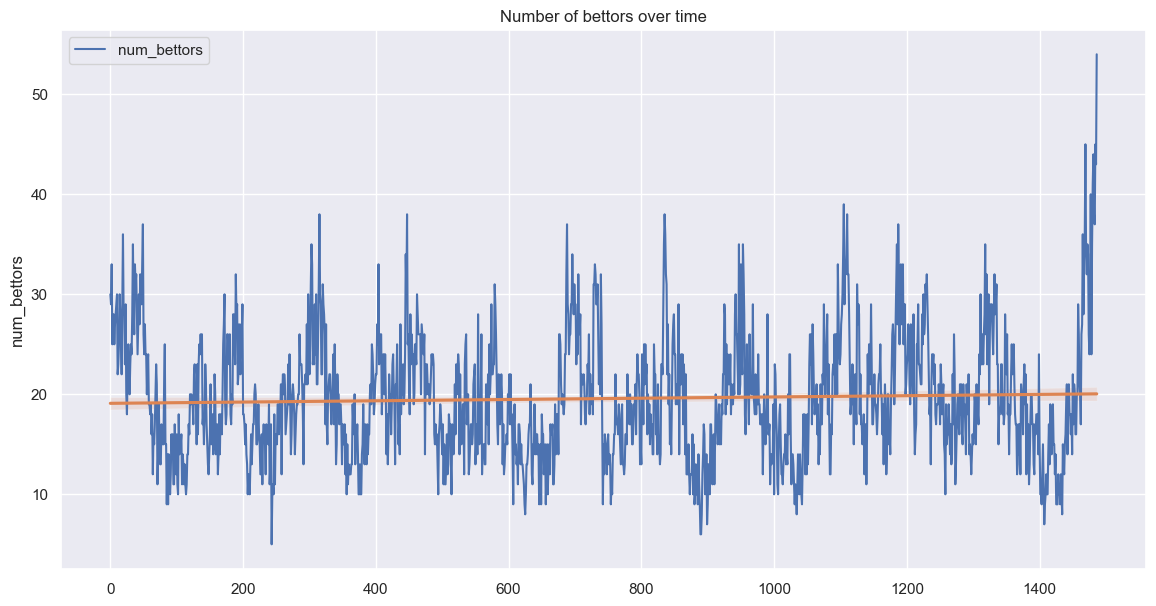

In [8]:
ax = data.plot(y="num_bettors",figsize=(14,7), title="Number of bettors over time")
sns.regplot(x=data.index, y=data.num_bettors, scatter=False, ax=ax)
# sns.kdeplot(y=data.num_bettors)
plt.show()

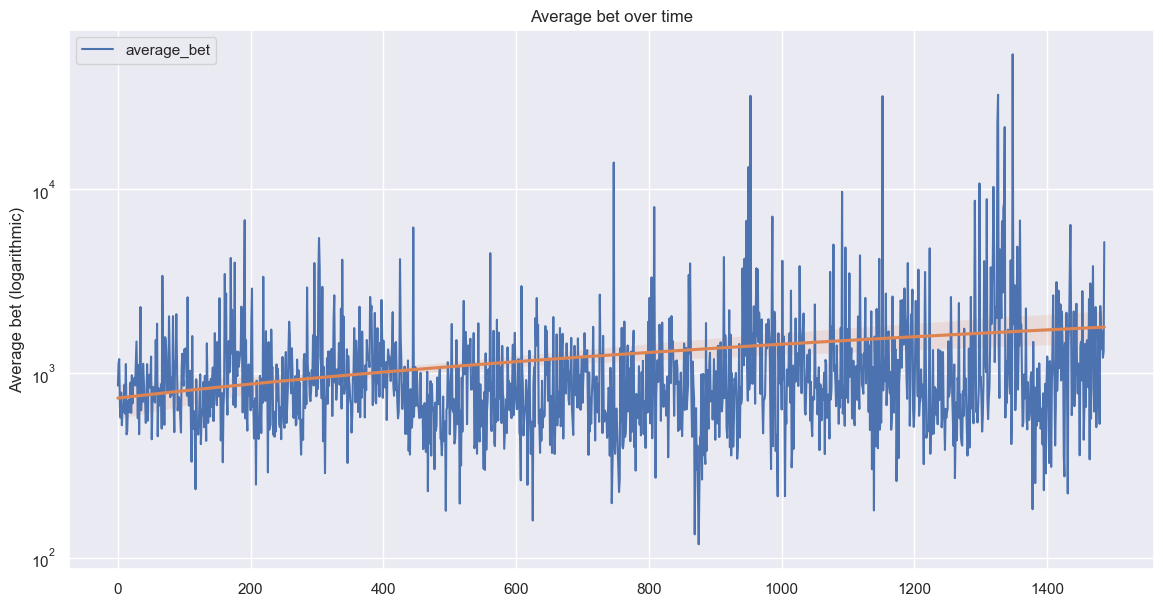

In [9]:
ax = nonzero_bets.plot(y="average_bet", logy=True, figsize=(14,7), title="Average bet over time")
sns.regplot(x=nonzero_bets.index, y=nonzero_bets.average_bet, scatter=False, ax=ax)
ax.set(ylabel="Average bet (logarithmic)")
plt.show()

<Figure size 640x480 with 0 Axes>

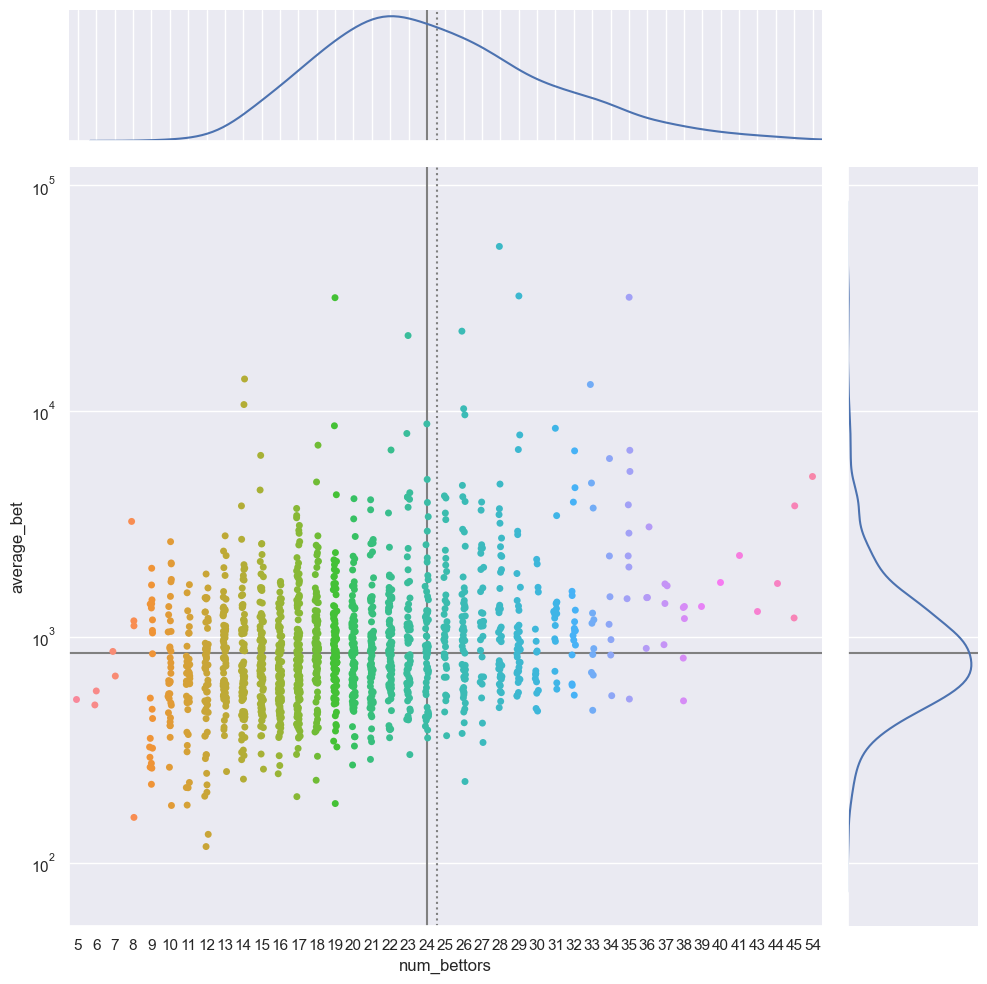

<Figure size 640x480 with 0 Axes>

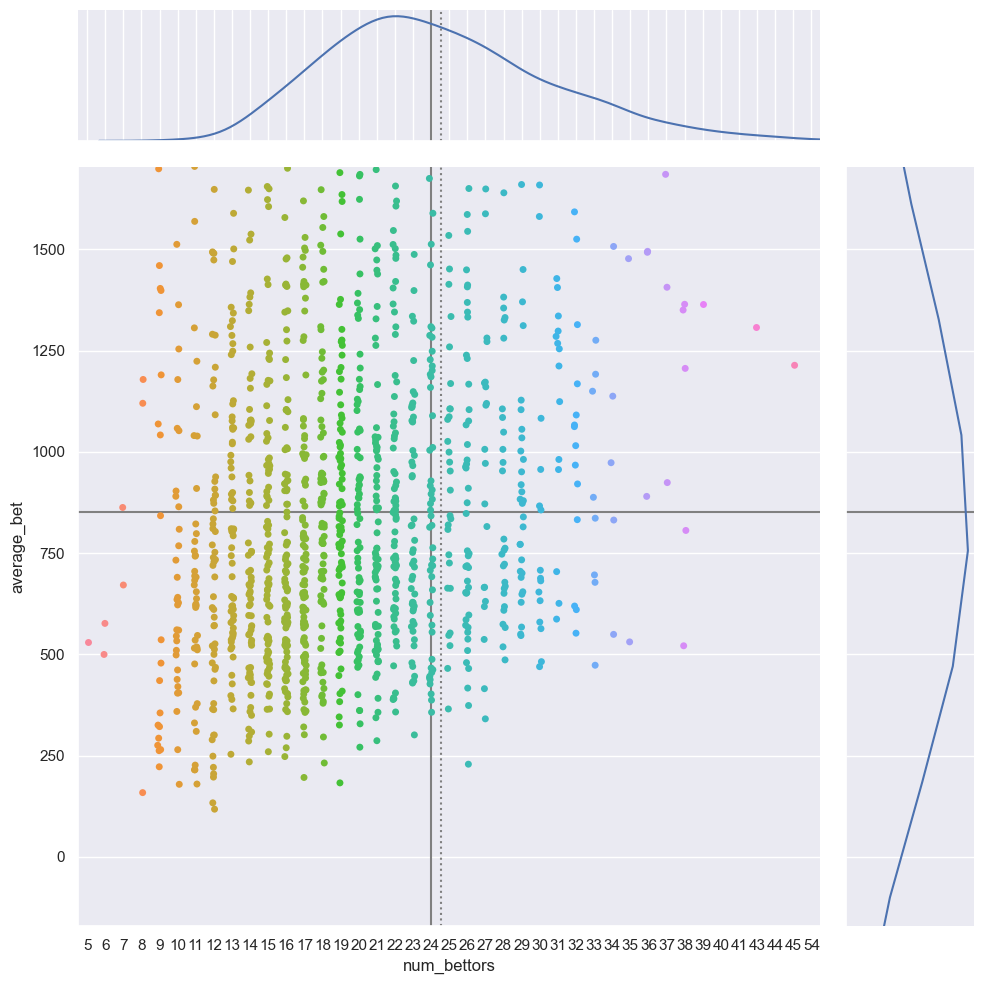

In [10]:
def fill_plot():
    g.refline(x=x.mean(), linestyle=":")
    g.refline(x=x.median(), y=y.median(), linestyle="-")
    sns.stripplot(x=x, y=y, s=5, ax=g.ax_joint)
    sns.kdeplot(x=x, ax=g.ax_marg_x)
    sns.kdeplot(y=y, ax=g.ax_marg_y)
    plt.xticks(rotation=90)
    
x, y = nonzero_bets.num_bettors, nonzero_bets.average_bet

f = plt.figure()
g = sns.JointGrid(x=x, y=y,
                   xlim=(nonzero_bets.num_bettors.min()-1,nonzero_bets.num_bettors.max()+1),
                   height=10,
                  )
g.ax_joint.set_yscale("log")
fill_plot()

median_thresh = y.median() * 2
if(y.max() > median_thresh * 10):
    f = plt.figure()
    g = sns.JointGrid(x=x, y=y,
                    xlim=(nonzero_bets.num_bettors.min()-1,nonzero_bets.num_bettors.max()+1),
                    height=10,
                    ylim=((-0.1*median_thresh),median_thresh)
                  )
    fill_plot()

plt.show()

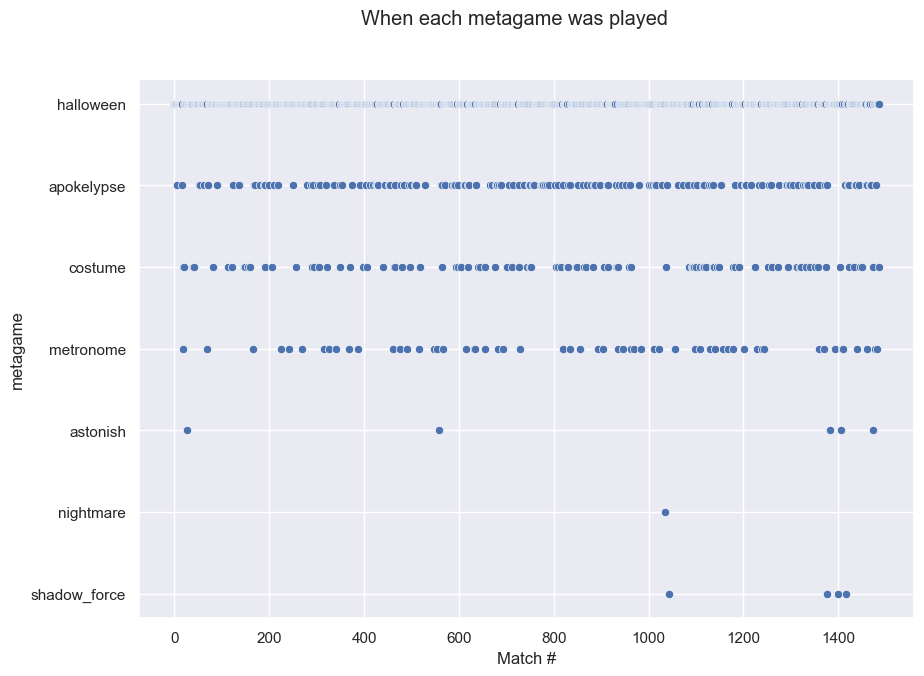

In [11]:
if "metagame" in keys:
    f = plt.figure(figsize=(10,7))
    f.suptitle("When each metagame was played")
    ax = sns.scatterplot(x=data.index,y=data.metagame)
    ax.set(xlabel="Match #")
    plt.show()
else:
    print("No metagames this season :(")

# Metagames

## Setup

In [12]:
if "metagame" in keys:
    threshold = 0.005 * data.index.max() # remove metagames that appear less than this amount of times, since they are likely token matches
    meta = nonzero_bets[nonzero_bets.groupby("metagame").metagame.transform("count") > threshold]
    metagames = nonzero_bets.metagame.unique().tolist()
    for m in meta.metagame.unique().tolist():
        metagames.remove(m)
    print("removed very rare metagames: " + str(metagames))

removed very rare metagames: ['astonish', 'nightmare', 'shadow_force']


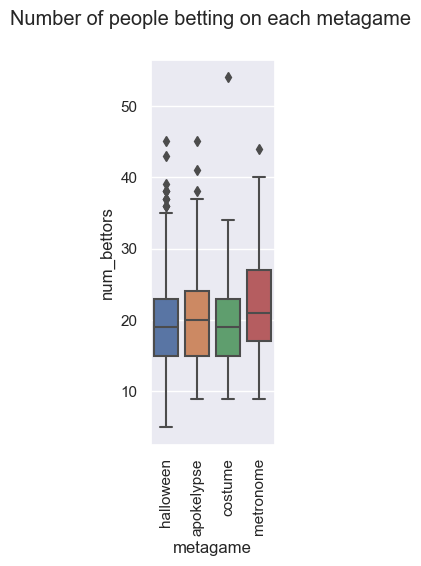

In [13]:
if "metagame" in keys:
    f = plt.figure(figsize=(len(meta.metagame.unique())/2.5,5))
    f.suptitle("Number of people betting on each metagame")
    sns.boxplot(x=meta.metagame, y=meta.num_bettors)
    plt.xticks(rotation=90)
    plt.show()

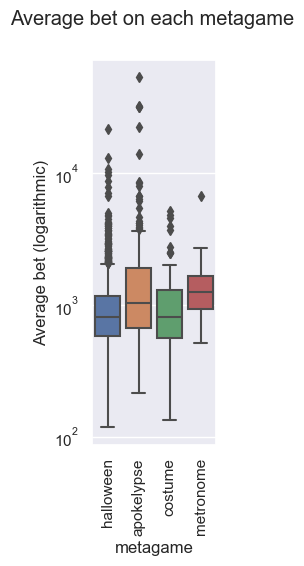

In [14]:
if "metagame" in keys:
    f = plt.figure(figsize=(len(meta.metagame.unique())/2.5,5))
    f.suptitle("Average bet on each metagame")
    ax = sns.boxplot(x=meta.metagame,y=meta.average_bet)
    ax.set(yscale="log", ylabel="Average bet (logarithmic)")
    plt.xticks(rotation=90)
    plt.show()

# Gimmicks

## Setup

In [15]:
if "gimmick" in keys:
    threshold_gim = 5 # absolute minimum amount of data we need to make any meaningful insight
    gim = nonzero_bets[nonzero_bets.groupby("gimmick").gimmick.transform("count") > threshold_gim]
    gimmicks = data.gimmick.unique().tolist()
    for g in gim.gimmick.unique().tolist():
        gimmicks.remove(g)
    print("removed infrequently used gimmicks: " + str(gimmicks))
else:
    print("no gimmicks this season :(")

removed infrequently used gimmicks: ['doubles_defiance_combo_of_4', 'spanish', 'german', 'japanese', 'french', 'italian']


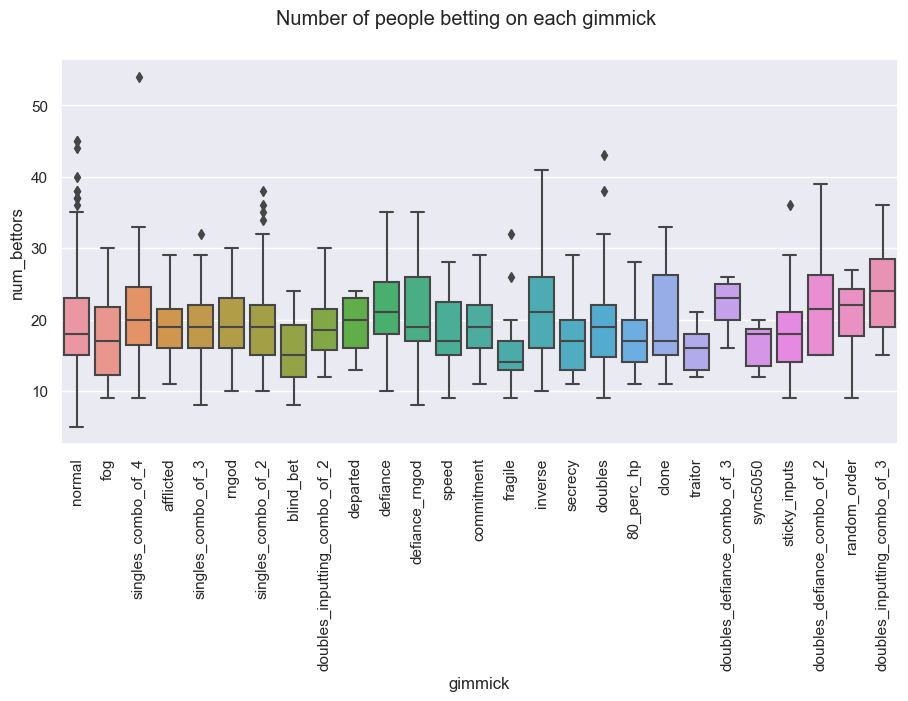

In [16]:
if "gimmick" in keys:
    f = plt.figure(figsize=(len(gim.gimmick.unique())/2.5,5))
    f.suptitle("Number of people betting on each gimmick")
    sns.boxplot(x="gimmick",y="num_bettors",data=gim)
    plt.xticks(rotation=90)
    plt.show()

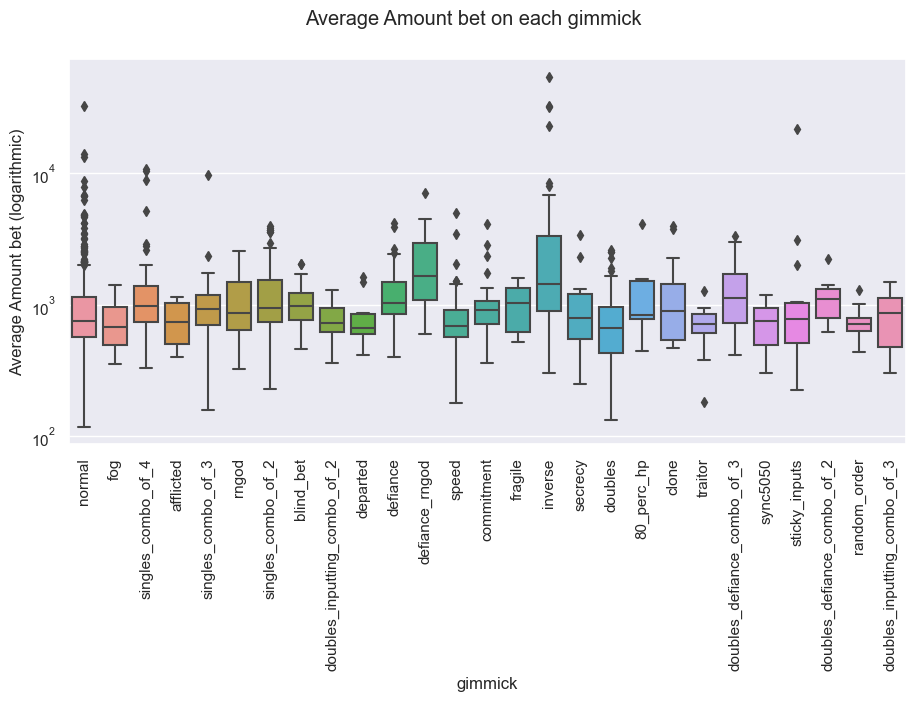

In [17]:
if "gimmick" in keys:
    f = plt.figure(figsize=(len(gim.gimmick.unique())/2.5,5))
    f.suptitle("Average Amount bet on each gimmick")
    ax = sns.boxplot(x=gim.gimmick, y=gim.average_bet)
    ax.set(yscale="log", ylabel="Average Amount bet (logarithmic)")
    plt.xticks(rotation=90)
    plt.show()

# Switching

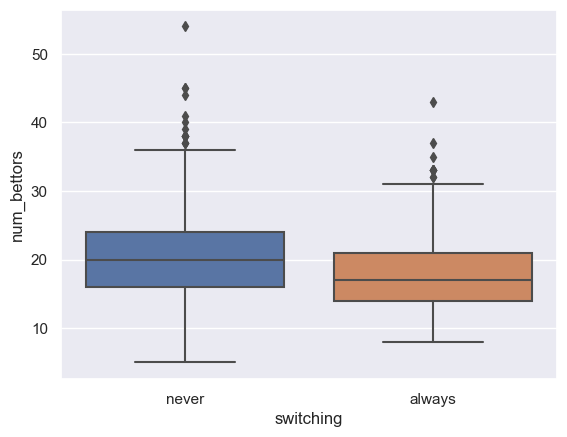

In [18]:
sns.boxplot(x=data.switching,y=data.num_bettors)
plt.show()

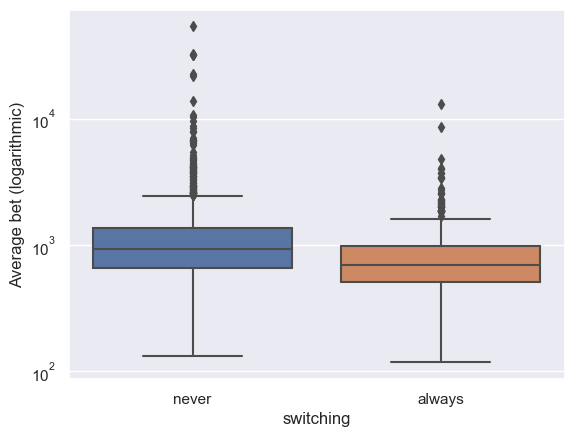

In [19]:
ax = sns.boxplot(x=data.switching,y=data.average_bet)
ax.set(yscale="log", ylabel="Average bet (logarithmic)")
plt.show()

# Odds vs winner
lower odds(<1) indicate more people bet on team 0 (probably red?), while higher(>1) odds indicate more people bet on team 1 (probably blue) 

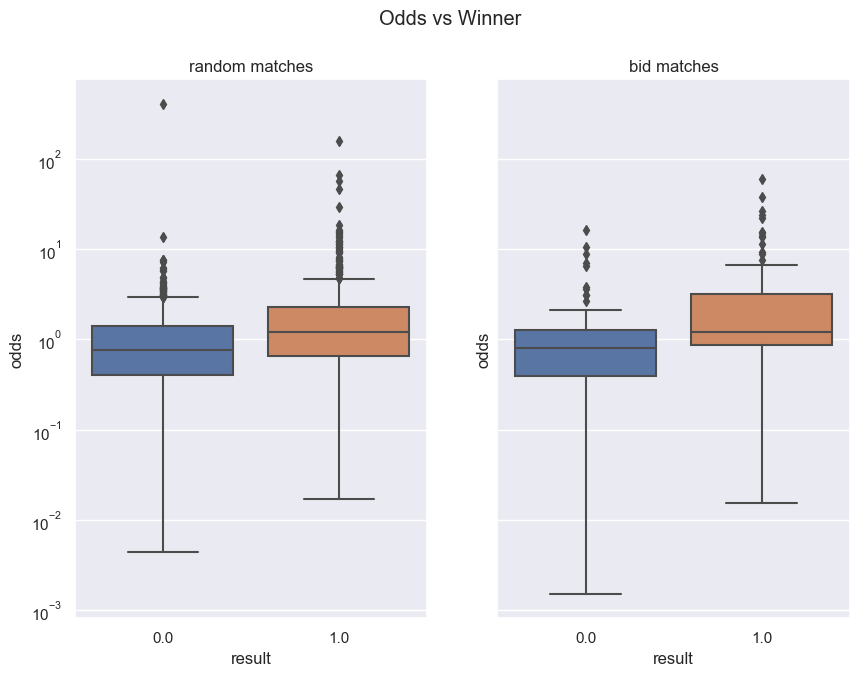

In [20]:
# remove entries where bets are all on 1 team
nonzero_bets = nonzero_bets[nonzero_bets.odds > 0.00001]

auto_matches = nonzero_bets[nonzero_bets.custom == False]
bid_matches = nonzero_bets[nonzero_bets.custom == True]

f, ax = plt.subplots(1, 2, figsize=(10,7),sharey=True)
f.suptitle("Odds vs Winner")
ax[0].set(yscale="log", title="random matches")
ax[1].set(title="bid matches")

sns.boxplot(x=auto_matches.result,y=auto_matches.odds, ax=ax[0])
sns.boxplot(x=bid_matches.result,y=bid_matches.odds)

plt.show()

# Bet bonus

In [21]:
if "bet_bonus_amount" in keys:
    should_draw_random_graph = auto_matches.bet_bonus_amount.mean() > 0
    should_draw_custom_graph = bid_matches.bet_bonus_amount.mean() > 0
    graphs_to_draw = should_draw_random_graph + should_draw_custom_graph
    i = 0

    f, ax = plt.subplots(graphs_to_draw, 1, figsize=(10,7),sharey=True)
    f.suptitle("Pokeyen injected from bet bonus")

    if should_draw_random_graph:
        if graphs_to_draw > 1:
            ax[i].set(yscale="log", title="random matches")
            sns.regplot(x=auto_matches.index,y=auto_matches.bet_bonus_amount, ax=ax[i])
            ax[i].set(ylabel="Pokeyen gained from bet bonus")
            i+=1
        else:
            ax.set(yscale="log", title="random matches")
            sns.regplot(x=auto_matches.index,y=auto_matches.bet_bonus_amount, ax=ax)
            ax.set(ylabel="Pokeyen gained from bet bonus")
    else:
        print("random matches had no bet bonus, skipping drawing graph")

    if should_draw_custom_graph:
        if graphs_to_draw > 1:
            ax[i].set(yscale="log", title="bid matches")
            sns.regplot(x=bid_matches.index,y=bid_matches.bet_bonus_amount, ax=ax[i])
            ax[i].set(ylabel="Pokeyen gained from bet bonus")
        else:
            ax.set(yscale="log", title="bid matches")
            sns.regplot(x=bid_matches.index,y=bid_matches.bet_bonus_amount, ax=ax)
            ax.set(ylabel="Pokeyen gained from bet bonus")
    else:
        print("bid matches had no bet bonus, skipping drawing graph")

    plt.show()

# Match predictability

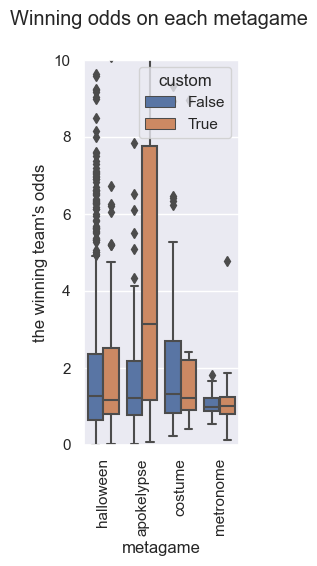

In [22]:
if "metagame" in keys:
    f = plt.figure(figsize=(len(meta.metagame.unique())/2,5))
    f.suptitle("Winning odds on each metagame")
    ax = sns.boxplot(x=meta.metagame,y=meta.winner_odds, hue=meta.custom)
    ax.set(ylabel="the winning team's odds", ylim=(0,10))
    plt.xticks(rotation=90)
    plt.show()

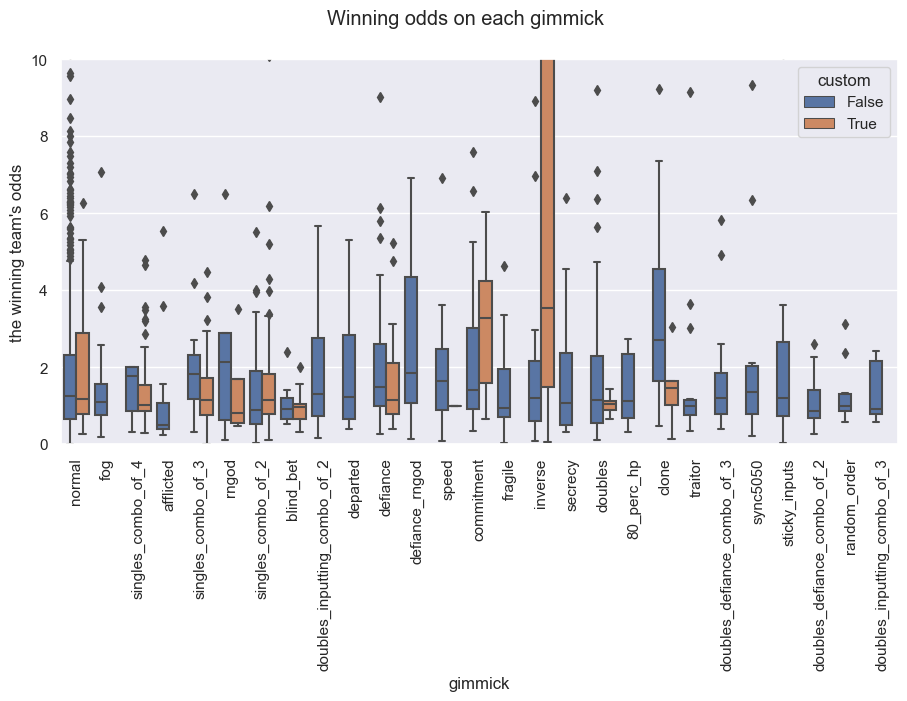

In [23]:
if "gimmick" in keys:
    f = plt.figure(figsize=(len(gim.gimmick.unique())/2.5,5))
    f.suptitle("Winning odds on each gimmick")
    ax = sns.boxplot(x=gim.gimmick,y=gim.winner_odds, hue=gim.custom)
    ax.set(ylabel="the winning team's odds", ylim=(0,10))
    plt.xticks(rotation=90)
    plt.show()